<a href="https://colab.research.google.com/github/rafiqulcse/Natural-Language-Processing-Project/blob/main/SOTA_with_XLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers -q

In [ ]:
!pip install sentencepiece

# After installing both of the packages -> Restart the runtime

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import transformers

import nltk
import re


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

plt.style.use('seaborn')

<ipython-input-2-00c26bc69615>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Load the dataset from the provided GitHub URL
github_url = "https://raw.githubusercontent.com/rafiqulcse/Natural-Language-Processing-Project/main/Dataset/NLP-project-dataset.csv"
dataf = pd.read_csv(github_url)

In [ ]:
dataf

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,0
3,for your own benefit you may want read living ...,1
4,you should all sit down together and watch the...,0
...,...,...
1995,just got the only one here who thought there ...,1
1996,asked here did not get many replies can anyon...,1
1997,haters gonna hate gonna hate gif,0
1998,sad that such success has now turned into pol...,0


In [ ]:
from transformers import TFXLNetModel, XLNetTokenizer

In [ ]:
xlnet_model = 'xlnet-large-cased'
xlnet_tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [ ]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')

    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs)[0]

    # CLASSIFICATION HEAD
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [ ]:
xlnet = create_xlnet(xlnet_model)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-large-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetM

In [ ]:
xlnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_inputs (InputLayer)    [(None, 120)]             0         
                                                                 
 tfxl_net_model (TFXLNetMod  TFXLNetModelOutput(last   360268800 
 el)                         _hidden_state=(None, 12             
                             0, 1024),                           
                              mems=((120, None, 1024             
                             ),                                  
                              (120, None, 1024),                 
                              (120, None, 1024),                 
                              (120, None, 1024),                 
                              (120, None, 1024),                 
                              (120, None, 1024),                 
                              (120, None, 1024),             

In [ ]:
tweets = dataf['clean_comment']
labels = dataf['category']

X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.15, random_state=196)

In [ ]:
def get_inputs(tweets, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

def warmup(epoch, lr):
    """Used for increasing the learning rate slowly, this tends to achieve better convergence.
    However, as we are finetuning for few epoch it's not crucial.
    """
    return max(lr +1e-6, 2e-5)

def plot_metrics(pred, true_labels):
    """Plots a ROC curve with the accuracy and the AUC"""
    acc = accuracy_score(true_labels, np.array(pred.flatten() >= .5, dtype='int'))
    fpr, tpr, thresholds = roc_curve(true_labels, pred)
    auc = roc_auc_score(true_labels, pred)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}\nACC: {acc}");
    return fig

In [ ]:
inp_tok, ids, segments = get_inputs(X_train, xlnet_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.02, restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(warmup, verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=1e-6, patience=2, verbose=0, mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-6)
]

In [ ]:
hist = xlnet.fit(x=inp_tok, y=y_train, epochs=3, batch_size=16, validation_split=.15, callbacks=callbacks)

Epoch 1/3
91/91 [==============================] - 166s 2s/step - loss: 0.8948 - accuracy: 0.5841 - precision: 0.6731 - recall: 0.7469 - val_loss: 1.5600 - val_accuracy: 0.3294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/3
91/91 [==============================] - 158s 2s/step - loss: 0.7855 - accuracy: 0.5917 - precision: 0.6690 - recall: 0.7828 - val_loss: 0.6630 - val_accuracy: 0.6706 - val_precision: 0.6706 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/3
91/91 [==============================] - 157s 2s/step - loss: 0.7151 - accuracy: 0.6304 - precision: 0.6851 - recall: 0.8381 - val_loss: 0.6806 - val_accuracy: 0.6706 - val_precision: 0.6706 - val_recall: 1.0000 - lr: 0.0010


In [ ]:
inp_tok, ids, segments = get_inputs(X_test, xlnet_tokenizer)

In [ ]:
preds = xlnet.predict(inp_tok, verbose=True)

10/10 [==============================] - 14s 957ms/step


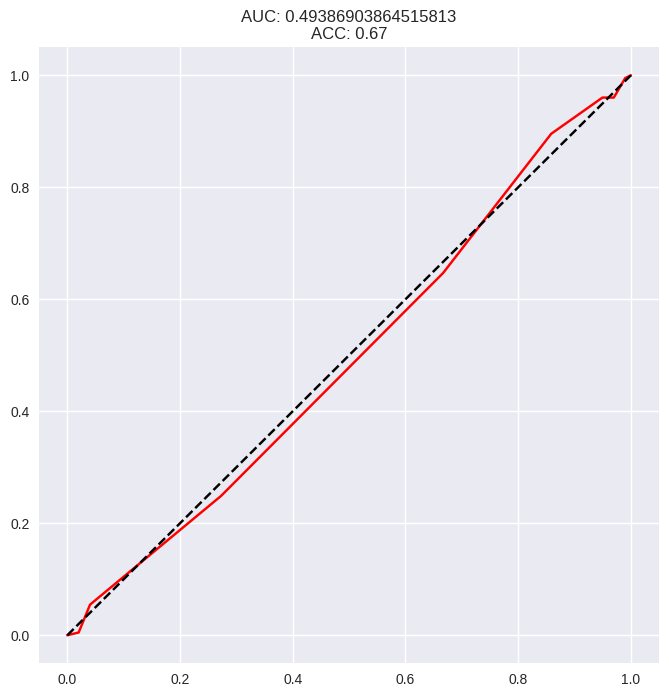

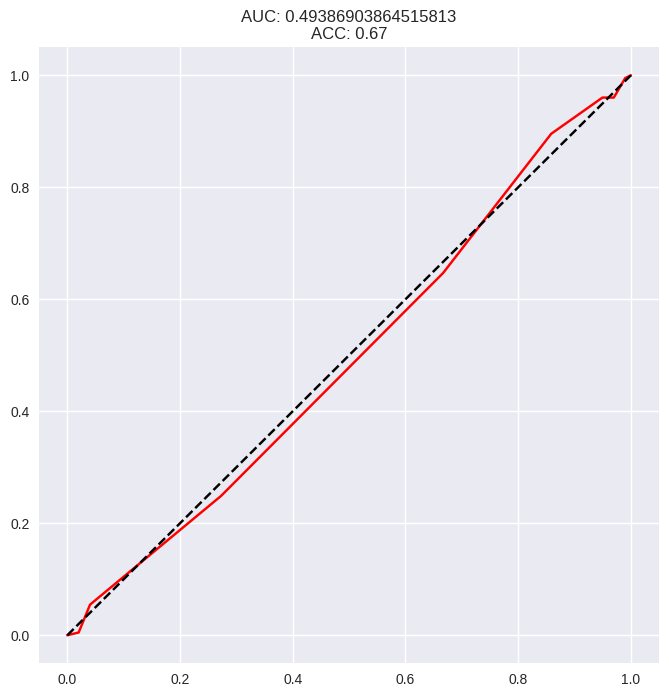

In [ ]:
plot_metrics(preds, y_test)